<h1>Experiments with feature detection algorithms</h1>

The goal is to test / develop algorithms for automated spectral line detection. These will eventually make their way into a specviz plug-in.

(from ticket #304):

The simplest useful detection algorithm is the following:

 - Convolve the spectrum with a fixed kernel (usually a Gaussian with FWHM corresponding to the spectral resolution).
 - Divide by the RMS noise and search for pixels above or below a fixed S/N threshold. These are the emission or absorption line centers.


In [17]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
# constants for all plots
x_label = '$\lambda$($\AA$)'
y_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
plot_axis = [1100., 1500., -0.5e-13, 6.e-13]

<h3>Get raw data</h3>

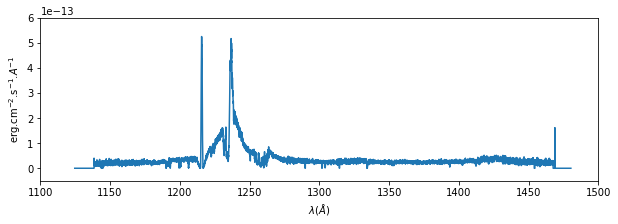

In [18]:
hdulist = fits.open('data/combined_13330_G130M_v40_bin4.fits')
flux = hdulist[1].data['flux'][0]
wave = hdulist[1].data['wavelength'][0]

# plot flux against data point index so we can visually build a mask
indices = np.array(list(range(len(wave))))
plt.figure(figsize=(10, 3))
plt.plot(wave, flux)
plt.axis(plot_axis)
plt.xlabel(x_label)
plt.ylabel(y_label)

<h3>Extract regions of interest </h3>

Here we extract two ROIs: 
 - the exact same ROI displayed in issue #145 (1.09$\mu$ < wavelength < 2.25$\mu$)
 - a slightly wider ROI (0.9$\mu$ < wavelength < 2.35$\mu$) that includes some contamination at the edges to test the fitter's sensitivity to ROI selection.

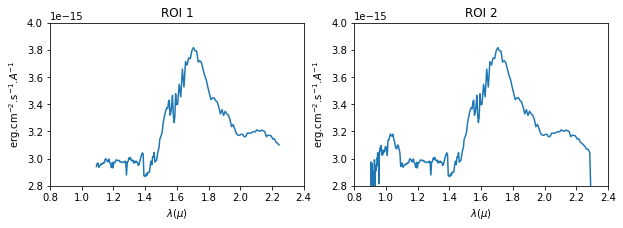

In [4]:
indices = (wave > 1.09) & (wave < 2.25) 
w1 = wave[indices]
f1 = flux[indices]
indices = (wave > 0.9) & (wave < 2.35) 
w2 = wave[indices]
f2 = flux[indices]

plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.axis(plot_axis)
plt.plot(w1, f1)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("ROI 1")

plt.subplot(122)
plt.axis(plot_axis)
plt.plot(w2, f2)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("ROI 2")

<h3>Build compound models</h3>